In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sys

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Source:
# http://blog.nextgenetics.net/?e=102
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Final Capstone
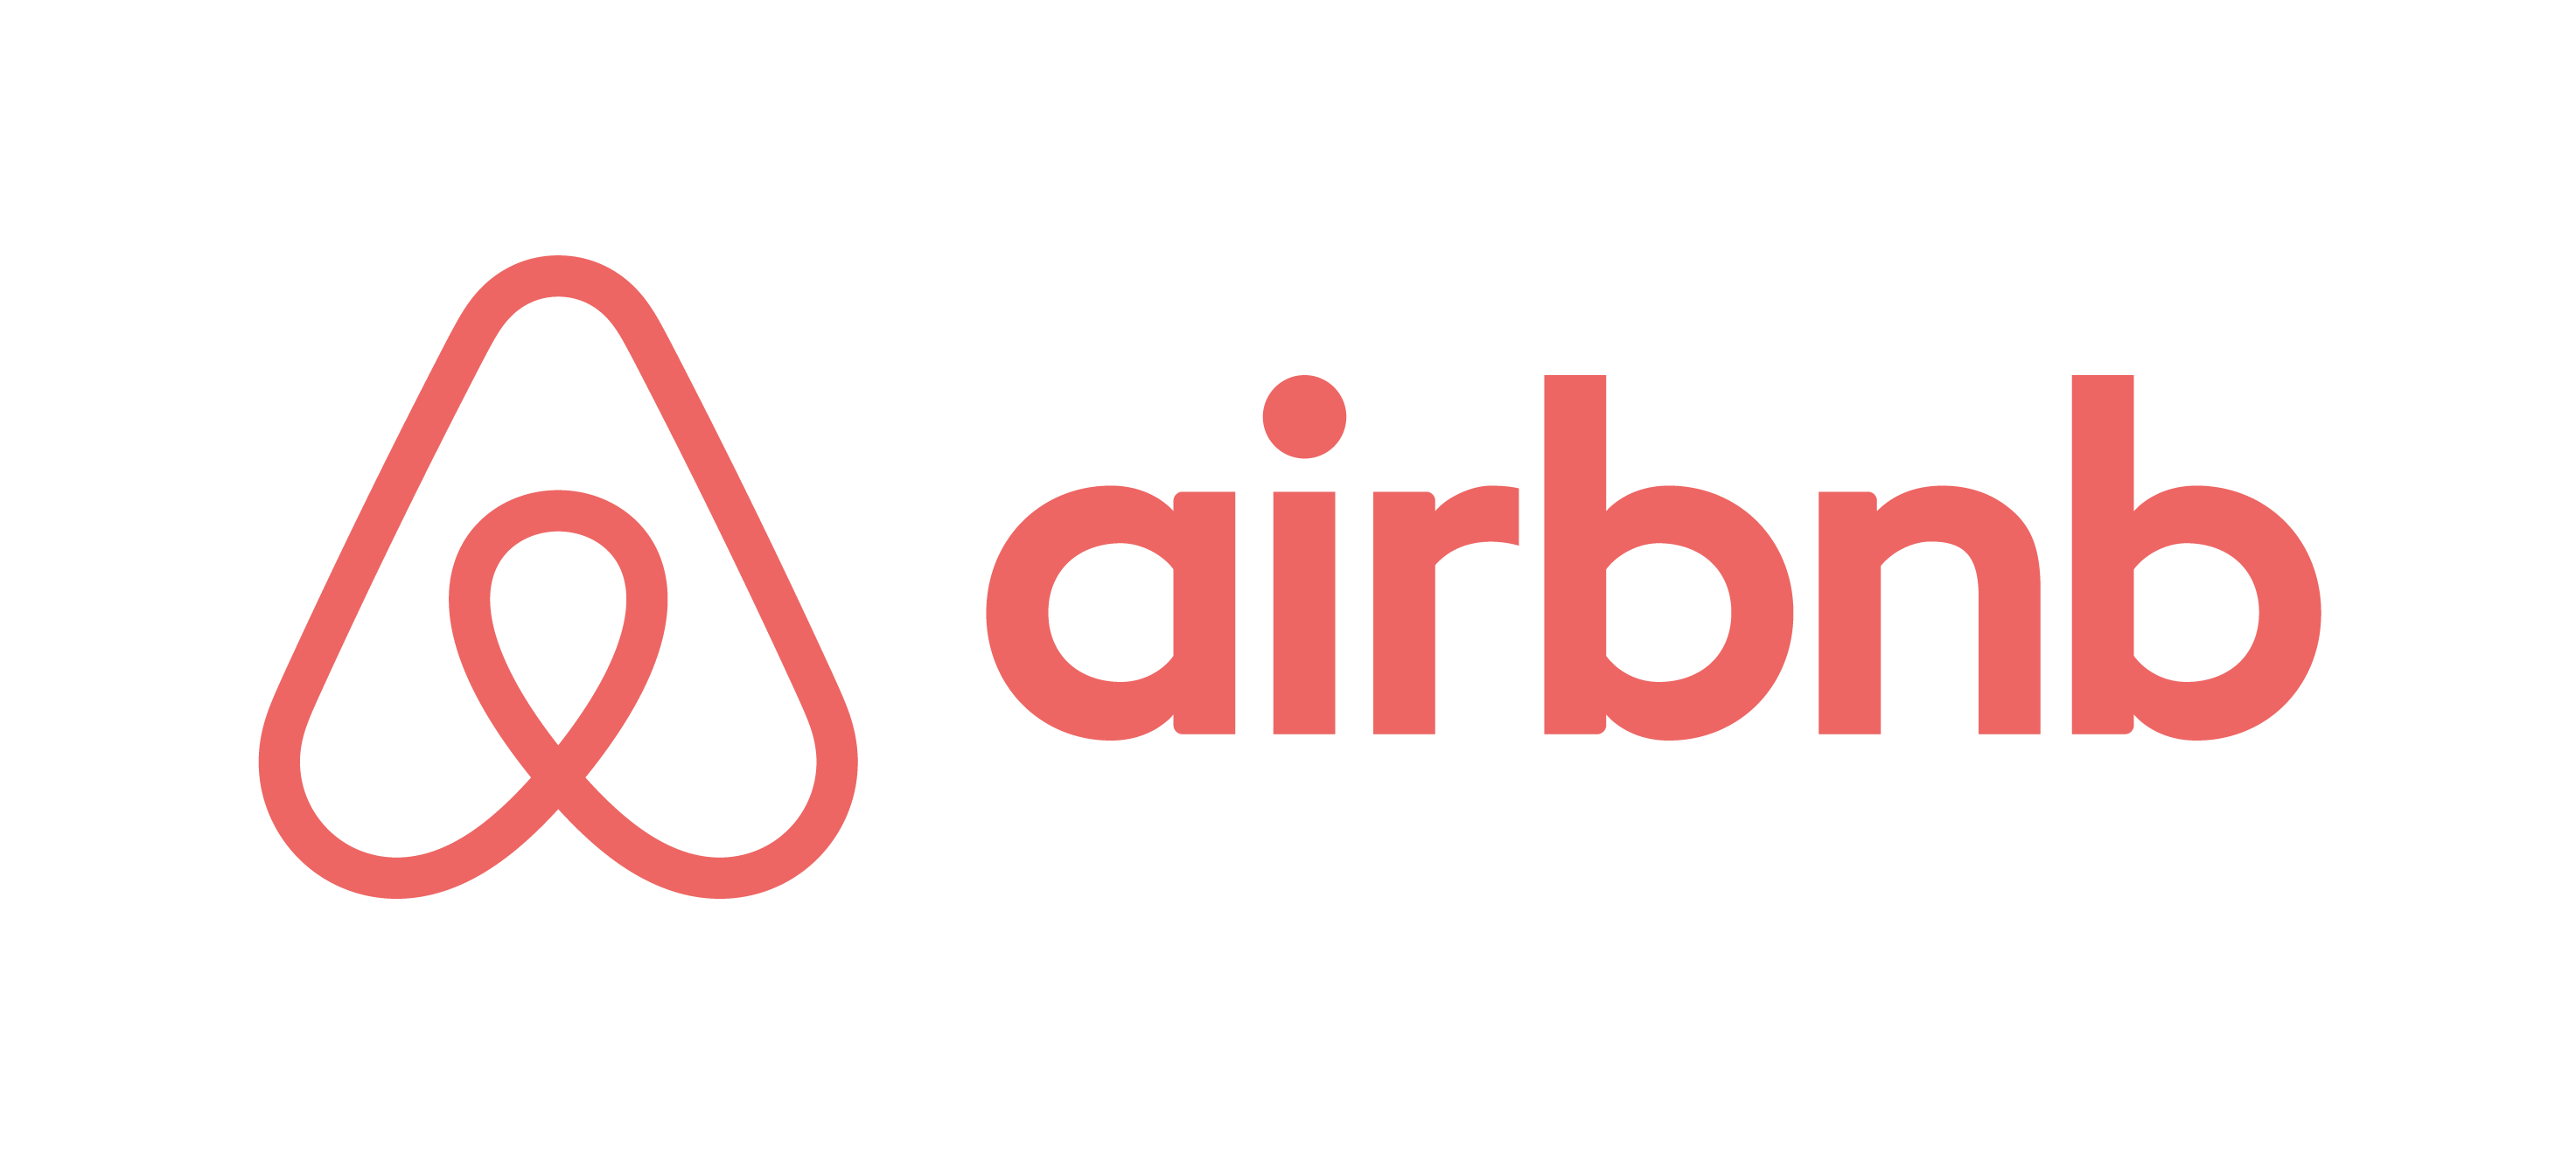
### Nick Chused
### July 3, 2020

My final capstone seeks to predict the price someone can expect to pay for a rental property in New York City through the Airbnb marketplace.

Using a large NYC Airbnb dataset, I have analyzed a variety of features, such as room type, borough, neighborhood, number of listings by the host, and year-round availability, to predict the cost per night of a given rental property.

The end product of my research seeks to provide the user with the ability to input the features they're looking for in a NYC Airbnb and then get a rough estimate of their expected cost.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Let's take a look at the dataset:

In [13]:
air = pd.read_csv('/content/gdrive/My Drive/Thinkful/AB_NYC_2019.csv')
air.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


The dataset contains fifteen self-explanatory features, and the target variable(price).  I drop name, host_id, host_name, and the date of the last_review, as these features intuitively are unlikely to affect the price of a rental property. 

In [14]:
air = air.drop(columns = ['id', 'name', 'host_id', 'host_name','last_review'])
air.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


Data exploration:

In [15]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [16]:
air.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [17]:
air.isnull().sum().sort_values(ascending=False)

reviews_per_month                 10052
availability_365                      0
calculated_host_listings_count        0
number_of_reviews                     0
minimum_nights                        0
price                                 0
room_type                             0
longitude                             0
latitude                              0
neighbourhood                         0
neighbourhood_group                   0
dtype: int64

Data cleaning and feature engineering:

For the 10052 listing without an entry for 'reviews per month', I replaced the empty entries with a value of 0.

In [18]:
air['reviews_per_month'] = air['reviews_per_month'].fillna(0)

In [19]:
air.corr().price.sort_values(ascending=False)

price                             1.000000
availability_365                  0.081829
calculated_host_listings_count    0.057472
minimum_nights                    0.042799
latitude                          0.033939
number_of_reviews                -0.047954
reviews_per_month                -0.050564
longitude                        -0.150019
Name: price, dtype: float64

Histogram of rental prices per night:

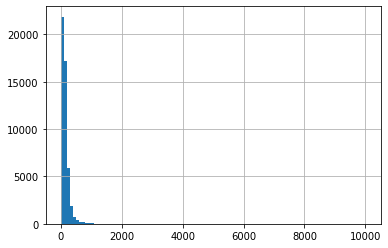

In [20]:
hist_price = air['price'].hist(bins=100)

Cleaning the data to only include prices below $1000 

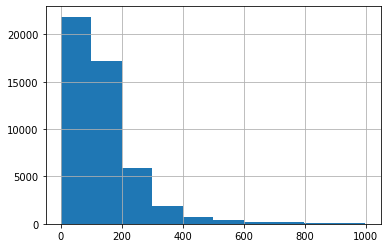

In [21]:
hist_price2 = air['price'][air['price']<1000].hist()

Number of entries in the dataset for Airbnb rentals with a price greater than $1000:

In [22]:
air[air['price']>1000].count()

neighbourhood_group               239
neighbourhood                     239
latitude                          239
longitude                         239
room_type                         239
price                             239
minimum_nights                    239
number_of_reviews                 239
reviews_per_month                 239
calculated_host_listings_count    239
availability_365                  239
dtype: int64

Number of entries in the dataset for Airbnb rentals with a price greater than $250:

In [23]:
air[air['price']>250].count()

neighbourhood_group               5208
neighbourhood                     5208
latitude                          5208
longitude                         5208
room_type                         5208
price                             5208
minimum_nights                    5208
number_of_reviews                 5208
reviews_per_month                 5208
calculated_host_listings_count    5208
availability_365                  5208
dtype: int64

I cleaned the data to only include prices below $250

In [24]:
air = air[air['price']<250]

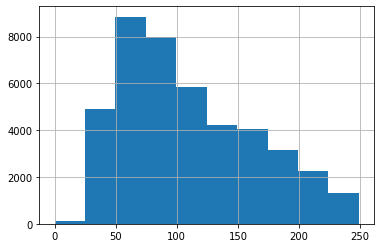

In [25]:
hist_price3 = air['price'].hist()

Histogram of the minimum number of nights required to rent the property:

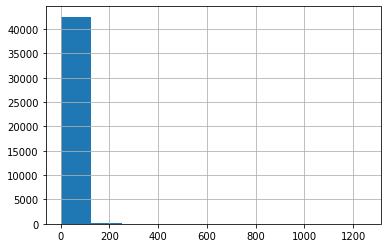

In [26]:
hist_min_nights = air['minimum_nights'].hist()

Histogram of the minimum number of required nights below 10:

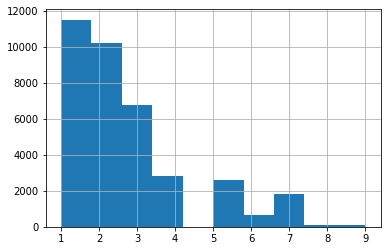

In [27]:
hist_min_nights = air['minimum_nights'][air['minimum_nights']<10].hist()

Number of entries in the dataset for Airbnb rentals with a minimum number of nights greater than 10:

In [28]:
air[air['minimum_nights']>10].count()

neighbourhood_group               5687
neighbourhood                     5687
latitude                          5687
longitude                         5687
room_type                         5687
price                             5687
minimum_nights                    5687
number_of_reviews                 5687
reviews_per_month                 5687
calculated_host_listings_count    5687
availability_365                  5687
dtype: int64

Given how few rental properties required more than 10 nights, I decided to set the feature of minimum nights such that any property listed as having more than 10 minimum nights was converted to having only 10 minimum nights, affectively capping the minimum number of nights to 10.

In [29]:
air.loc[(air.minimum_nights>10), 'minimum_nights'] = 10

Histogram of the number of listings by host:

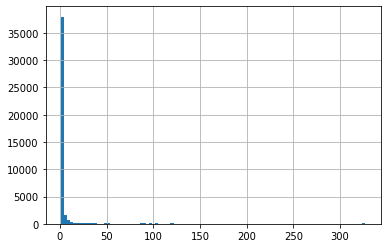

In [30]:
hist_listings = air['calculated_host_listings_count'].hist(bins=100)

Histogram of the minimum host listing below 10:

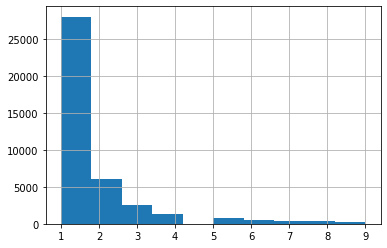

In [31]:
hist_listings = air['calculated_host_listings_count'][air['calculated_host_listings_count']<10].hist()

Number of entries in the dataset for Airbnb rentals a host listing count greater than 10:

In [32]:
air[air['calculated_host_listings_count']>10].count()

neighbourhood_group               2266
neighbourhood                     2266
latitude                          2266
longitude                         2266
room_type                         2266
price                             2266
minimum_nights                    2266
number_of_reviews                 2266
reviews_per_month                 2266
calculated_host_listings_count    2266
availability_365                  2266
dtype: int64

Given how few rental property hosts had more than 10 listings, I decided to set the feature of listings such that any property hosts having more than 10 listings was converted to having only 10 listings, affectively capping the number of host listings to 10.

In [33]:
air.loc[(air.calculated_host_listings_count>10), 'calculated_host_listings_count'] = 10

In [34]:
air.corr().price.sort_values(ascending=False)

price                             1.000000
latitude                          0.064524
minimum_nights                    0.056576
availability_365                  0.043715
number_of_reviews                -0.004717
calculated_host_listings_count   -0.009030
reviews_per_month                -0.044371
longitude                        -0.306625
Name: price, dtype: float64

Determining the affect of the object variables on the target variable

In [35]:
objects = air.select_dtypes(['object']).columns
objects

Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')

Graphs of the average rental price with respect to neighboorhood group, neighboorhood, and room type:

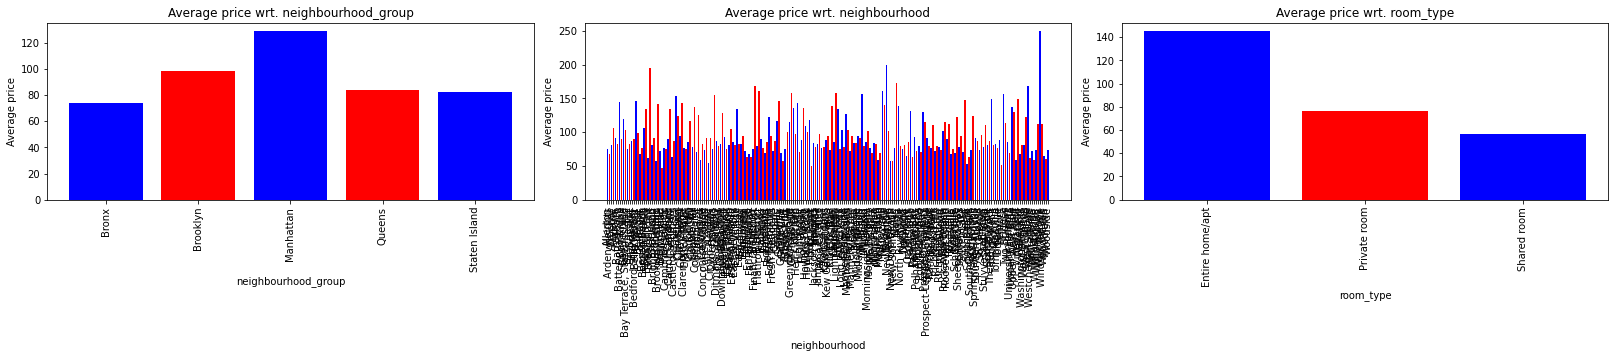

In [36]:
plt.figure(figsize=(30,50))

for index, column in enumerate(objects):
    plt.subplot(11,4,index+1)
    plt.bar(air.groupby(column)['price'].mean().index, air.groupby(column)['price'].mean(),
           color=("blue","red"))
    plt.title("Average price wrt. {}".format(column))
    plt.ylabel("Average price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [37]:
air['neighbourhood'].value_counts()

Bedford-Stuyvesant    3560
Williamsburg          3451
Harlem                2487
Bushwick              2404
Upper West Side       1570
                      ... 
Rossville                1
Willowbrook              1
Richmondtown             1
Neponsit                 1
New Dorp                 1
Name: neighbourhood, Length: 219, dtype: int64

In [38]:
air2 = air.groupby('neighbourhood').filter(lambda x: x['neighbourhood'].count() > 25)
air2.neighbourhood.unique()

array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Prospect Heights', 'Washington Heights',
       'Upper East Side', 'Woodside', 'Carroll Gardens', 'Gowanus',
       'Flatlands', 'Cobble Hill', 'Flushing', 'Sunnyside', 'St. George',
       'Highbridge', 'Financial District', 'Morningside Heights',
       'Jamaica', 'Middle Village', 'Ridgewood', 'NoHo',
       'Ditmars Steinway', 'Roosevelt Island', 'Greenwich Village',
       'Little Italy', 'East Flatbush', 'Tompkinsville', 'Astoria',
       'Kingsbridge', 'Boerum Hill', 'Brooklyn Heights', 'Two Bridges',
 

In [39]:
air2.neighbourhood.count()

41694

In [40]:
air2.corr().price.sort_values(ascending=False)

price                             1.000000
latitude                          0.075618
minimum_nights                    0.055881
availability_365                  0.049677
number_of_reviews                -0.004826
calculated_host_listings_count   -0.006690
reviews_per_month                -0.042602
longitude                        -0.333494
Name: price, dtype: float64

Graphs of the average rental price with respect to neighboorhood group, neighboorhood, and room type, after filtering the number of neighboorhoods to contain only those neighboorhoods with more than 25 listings:

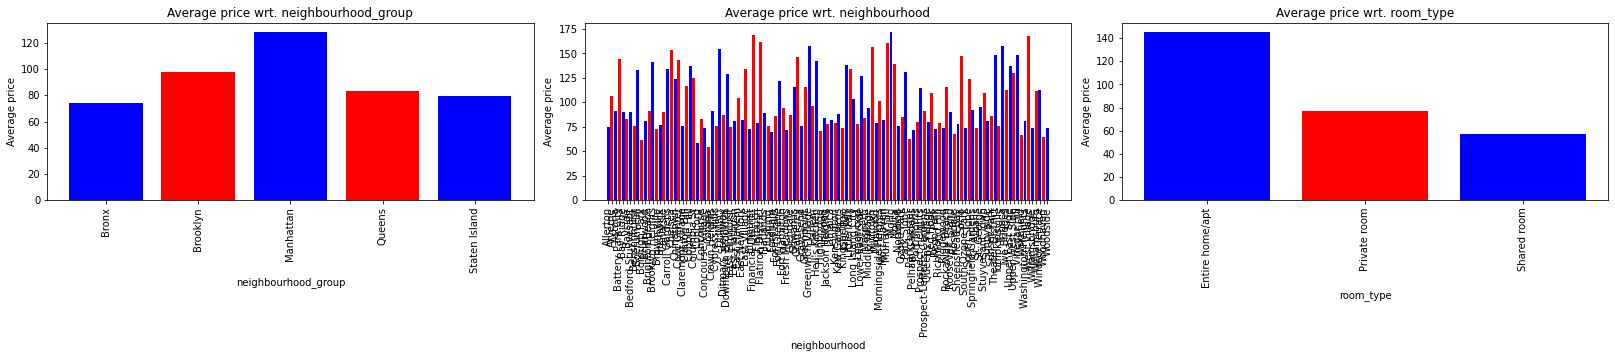

In [41]:
plt.figure(figsize=(30,50))

for index, column in enumerate(objects):
    plt.subplot(11,4,index+1)
    plt.bar(air2.groupby(column)['price'].mean().index, air2.groupby(column)['price'].mean(),
           color=("blue","red"))
    plt.title("Average price wrt. {}".format(column))
    plt.ylabel("Average price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

After being unable to sufficiently narrow down the number of specific neighbourhoods within each of the five boroughs, I decided to drop the neighbourhood feature.

In [42]:
air3 = air2.drop(['neighbourhood'], axis = 1)
air3.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


A graph summerizing the prices of different room types among the five boroughs:

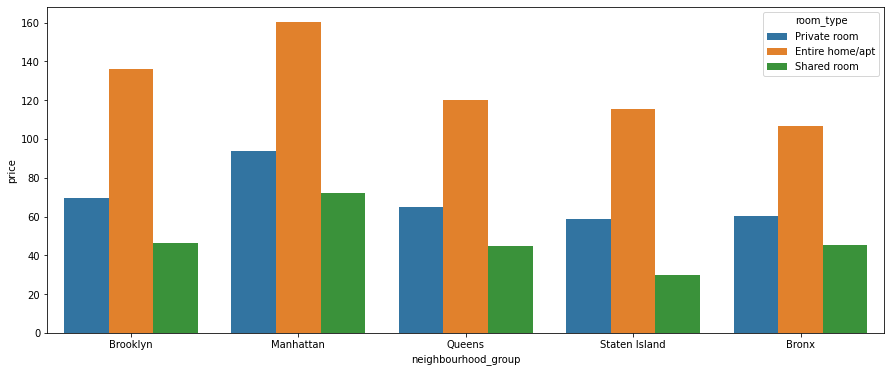

In [43]:
plt.figure(figsize=(15, 6))
sns.barplot(x=air3.neighbourhood_group,y=air3.price,hue=air3.room_type,ci=False)
plt.show()

I convert the neighbourhood_group and room_type features to dummy variables.

In [44]:
air4 = pd.concat([air3, pd.get_dummies(air3.neighbourhood_group, 
                                        prefix='neighbourhood_group', drop_first=True)], axis = 1)
air5 = pd.concat([air4, pd.get_dummies(air4.room_type, 
                                        prefix='room_type', drop_first=True)], axis = 1)
dummy_column_names = list(pd.get_dummies(air5.neighbourhood_group, prefix = 'neighbourhood_group').columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(air5.room_type, prefix = 'room_type').columns)

In [45]:
air5.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room
0,Brooklyn,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,1,0,0,0,1,0
1,Manhattan,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,0,1,0,0,0,0
2,Manhattan,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,0,1,0,0,1,0
3,Brooklyn,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,1,0,0,0,0,0
4,Manhattan,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,0,1,0,0,0,0


In [46]:
air5 = air5.drop(columns = ['neighbourhood_group', 'room_type'])
air5.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,365,1,0,0,0,1,0
1,40.75362,-73.98377,225,1,45,0.38,2,355,0,1,0,0,0,0
2,40.80902,-73.94190,150,3,0,0.00,1,365,0,1,0,0,1,0
3,40.68514,-73.95976,89,1,270,4.64,1,194,1,0,0,0,0,0
4,40.79851,-73.94399,80,10,9,0.10,1,0,0,1,0,0,0,0


In [47]:
air5.corr().price.sort_values(ascending=False)

price                                1.000000
neighbourhood_group_Manhattan        0.315380
latitude                             0.075618
minimum_nights                       0.055881
availability_365                     0.049677
number_of_reviews                   -0.004826
calculated_host_listings_count      -0.006690
neighbourhood_group_Staten Island   -0.027932
reviews_per_month                   -0.042602
room_type_Shared room               -0.156496
neighbourhood_group_Brooklyn        -0.173375
neighbourhood_group_Queens          -0.175632
longitude                           -0.333494
room_type_Private room              -0.592583
Name: price, dtype: float64

Now I split the data into training and testing sets to determine how well different model can predict property price based on the remaining features. 

In [48]:
Y = air5.price
X = air5.drop(['price'], axis = 1)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 33355
The number of observations in test set is 8339


OLS regression:

In [49]:
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     2803.
Date:                Wed, 01 Jul 2020   Prob (F-statistic):               0.00
Time:                        13:32:15   Log-Likelihood:            -1.6793e+05
No. Observations:               33355   AIC:                         3.359e+05
Df Residuals:                   33341   BIC:                         3.360e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

A graph of predicted and true values:

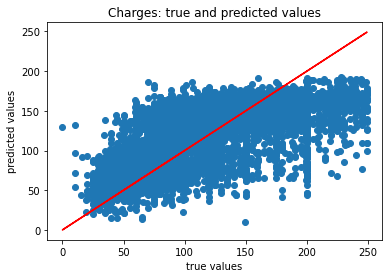

In [50]:
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

Summary of linear regression results:

In [58]:
lrm = LinearRegression()
lrm.fit(X_train, y_train)

y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.5212487351570545
-----Test set statistics-----
R-squared of the model in the test set is: 0.5264199861908949
Mean absolute error of the prediction is: 29.052318032177787
Mean squared error of the prediction is: 1384.9665822243999
Root mean squared error of the prediction is: 37.21513915363477
Mean absolute percentage error of the prediction is: inf


I explore using Lasso regression to improve R-squared values and reduce mean absolute error.  There is virtually no difference in model performance.

In [52]:
alphas = [np.power(10.0, p) for p in np.arange(-10,40,1)]

In [53]:
lasso_cv = LassoCV(alphas=alphas, cv=5).fit(X,Y)

print("R-squared of the model after lasso is: {}".format(lasso_cv.score(X,Y)))

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model after lasso is: 0.5223606418291984
Best alpha value is: 1e-10
R-squared of the model in training set is: 0.5221962448604891
-----Test set statistics-----
R-squared of the model in test set is: 0.5229468697252733
Mean absolute error of the prediction is: 28.832306506258906
Mean squared error of the prediction is: 1396.3039109765418
Root mean squared error of the prediction is: 37.367150158615814
Mean absolute percentage error of the prediction is: inf


Testing diffrerent models to determine the model that provides the highest accuracy:

I again convert the neighbourhood_group and room_type features to dummy variables.  However, this time I do not drop the first dummy variables for the purpose of running regression models.

In [59]:
air6 = pd.concat([air3, pd.get_dummies(air3.neighbourhood_group, 
                                        prefix='neighbourhood_group', drop_first=False)], axis = 1)
air7 = pd.concat([air6, pd.get_dummies(air6.room_type, 
                                        prefix='room_type', drop_first=False)], axis = 1)
dummy_column_names = list(pd.get_dummies(air7.neighbourhood_group, prefix = 'neighbourhood_group').columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(air7.room_type, prefix = 'room_type').columns)

In [60]:
air7 = air7.drop(columns = ['neighbourhood_group', 'room_type'])

In [61]:
air7

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,149,1,9,0.21,6,365,0,1,0,0,0,0,1,0
1,40.75362,-73.98377,225,1,45,0.38,2,355,0,0,1,0,0,1,0,0
2,40.80902,-73.94190,150,3,0,0.00,1,365,0,0,1,0,0,0,1,0
3,40.68514,-73.95976,89,1,270,4.64,1,194,0,1,0,0,0,1,0,0
4,40.79851,-73.94399,80,10,9,0.10,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,70,2,0,0.00,2,9,0,1,0,0,0,0,1,0
48891,40.70184,-73.93317,40,4,0,0.00,2,36,0,1,0,0,0,0,1,0
48892,40.81475,-73.94867,115,10,0,0.00,1,27,0,0,1,0,0,1,0,0
48893,40.75751,-73.99112,55,1,0,0.00,6,2,0,0,1,0,0,0,0,1


In [62]:
Y = air7.price
X = air7.drop(['price'], axis = 1)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 33355
The number of observations in test set is 8339


In [63]:
lrm.fit(X_train, y_train)

lin_reg_score = lrm.score(X_test, y_test)
lin_reg_predictions = lrm.predict(X_test)

print('R-squared of lin_reg: {:.3f}'.format(lin_reg_score))

R-squared of lin_reg: 0.517


In [64]:
knn = KNeighborsRegressor(n_neighbors=10)

knn.fit(X_train, y_train)

knn_score = knn.score(X_test, y_test)
knn_predictions = knn.predict(X_test)

print('R-squared of KNN (k = 10): {:.3f}'.format(knn_score))

R-squared of KNN (k = 10): 0.247


In [65]:
dt = DecisionTreeRegressor()

dt.fit(X_train, y_train)

dt_score = dt.score(X_test, y_test)
dt_predictions = dt.predict(X_test)

print('R-squared of a Decision Tree: {:.3f} '.format(dt_score))

R-squared of a Decision Tree: 0.210 


In [66]:
rf = RandomForestRegressor(n_estimators = 25)

rf.fit(X_train,y_train)

rf_score = rf.score(X_test, y_test)
rf_predictions = rf.predict(X_test)

print('R-sqaured of Random Forest: {:.3f}'.format(rf_score))

R-sqaured of Random Forest: 0.577


I standardize the data to see if it improves the accuracy of the regression models 

In [67]:
scaler = StandardScaler()
air7.loc[:, ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']] = scaler.fit_transform(air7.loc[:, ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]) 

In [68]:
air7.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,40.64749,-73.97237,149,-0.880385,-0.334964,-0.556432,1.614591,2.003199,0,1,0,0,0,0,1,0
1,40.75362,-73.98377,225,-0.880385,0.444888,-0.451421,-0.066739,1.925825,0,0,1,0,0,1,0,0
2,40.80902,-73.94190,150,-0.222522,-0.529927,-0.686151,-0.487071,2.003199,0,0,1,0,0,0,1,0
3,40.68514,-73.95976,89,-0.880385,5.318965,2.180027,-0.487071,0.680103,0,1,0,0,0,1,0,0
4,40.79851,-73.94399,80,2.079998,-0.334964,-0.624380,-0.487071,-0.820953,0,0,1,0,0,1,0,0


In [69]:
Y = air7.price
X = air7.drop(['price'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [70]:
lrm.fit(X_train, y_train)

lin_reg_score = lrm.score(X_test, y_test)
lin_reg_predictions = lrm.predict(X_test)

print('R-squared of lin_reg: {:.3f}'.format(lin_reg_score))

R-squared of lin_reg: 0.530


In [71]:
knn = KNeighborsRegressor(n_neighbors=10)

knn.fit(X_train, y_train)

knn_score = knn.score(X_test, y_test)
knn_predictions = knn.predict(X_test)

print('R-squared of KNN (k = 10): {:.3f}'.format(knn_score))

R-squared of KNN (k = 10): 0.518


In [72]:
dt = DecisionTreeRegressor()

dt.fit(X_train, y_train)

dt_score = dt.score(X_test, y_test)
dt_predictions = dt.predict(X_test)

print('R-squared of a Decision Tree: {:.3f} '.format(dt_score))

R-squared of a Decision Tree: 0.218 


In [73]:
rf = RandomForestRegressor(n_estimators = 25)

rf.fit(X_train,y_train)

rf_score = rf.score(X_test, y_test)
rf_predictions = rf.predict(X_test)

print('R-squared of Random Forest: {:.3f}'.format(rf_score))

R-squared of Random Forest: 0.589


Standardizing the data does not seem to have a significant impact on the accuracy of the regression models

Having explored many different regression models,
I now return to an earlier dataset to begin the process of predicting a rental property's price based only on the logical features than a user would input (neighbourhood group, room type, minimum number of nights the renter must commit to staying, and the number of listings by the host.

In [76]:
air8 = pd.concat([air3, pd.get_dummies(air3.neighbourhood_group, 
                                        prefix='neighbourhood_group', drop_first=False)], axis = 1)
air9 = pd.concat([air8, pd.get_dummies(air6.room_type, 
                                        prefix='room_type', drop_first=False)], axis = 1)
dummy_column_names = list(pd.get_dummies(air8.neighbourhood_group, prefix = 'neighbourhood_group').columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(air8.room_type, prefix = 'room_type').columns)

In [77]:
air10 = air3.drop(columns = ['latitude', 'longitude', 'number_of_reviews', 'reviews_per_month', 'availability_365'])

In [78]:
air10.head()

,neighbourhood_group,room_type,price,minimum_nights,calculated_host_listings_count
0,Brooklyn,Private room,149,1,6
1,Manhattan,Entire home/apt,225,1,2
2,Manhattan,Private room,150,3,1
3,Brooklyn,Entire home/apt,89,1,1
4,Manhattan,Entire home/apt,80,10,1


I map the neighboorhood groups and room types to numerical values to allow a user to more easily select a choice for each of these features

In [79]:
boroughs = {'Brooklyn': 1, 'Manhattan': 2, 'Queens': 3, 'Staten Island': 4, 'Bronx': 5}
air10.neighbourhood_group = air10.neighbourhood_group.map(boroughs)
room = {'Shared room': 1, 'Private room': 2, 'Entire home/apt': 3}
air10.room_type = air10.room_type.map(room)

In [80]:
air10.head()

,neighbourhood_group,room_type,price,minimum_nights,calculated_host_listings_count
0,1,2,149,1,6
1,2,3,225,1,2
2,2,2,150,3,1
3,1,3,89,1,1
4,2,3,80,10,1


In [81]:
Y = air10.price
X = air10.drop(['price'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 33355
The number of observations in test set is 8339


the random forest regressor produced the most accurate results, so I decided to use that model to predict price

In [82]:
results = rf.fit(X_train, y_train)

At this point the user inputs the minimum number of nights (between 1 and 10), the calculated number of listings made by the host (between 1 and 10), the neighbourhood group (Bronx, Brooklyn, Manhattan, Queens, or Staten Island), and the room type (entire home, private room, shared room).  Once the user has inputted this information they are then provided with an estimate for the cost of their rental price per night.

In [83]:
X.head()

,neighbourhood_group,room_type,minimum_nights,calculated_host_listings_count
0,1,2,1,6
1,2,3,1,2
2,2,2,3,1
3,1,3,1,1
4,2,3,10,1


In [85]:
borough = input("What borough would you like to stay in? (please choose: 1 for Brooklyn, 2 for Manhattan, 3 for Queens, \n 4 for Statan Island, and 5 for Bronx) \n")
X.neighbourhood_group = borough

room = input("What type of room would you like to stay in? (please choose: 1 for a shared room, 2 for a private room, \n and 3 for entire home/apartment) \n")
X.room_type = room

nights = input("What's the minimum number of nights you'll want to stay? (please choose a number between 1 and 10) \n")
X.minimum_nights = nights

listings = input("What's the minimum number of listings you'll want to see? (please choose a number between 1 and 10) \n")
X.calculated_host_listings_count = listings

print("\n On average, you can expect to pay ${} per night for your rental property".format("{:.2f}".format(results.predict(X)[0])))

What borough would you like to stay in? (please choose: 1 for Brooklyn, 2 for Manhattan, 3 for Queens, 
 4 for Statan Island, and 5 for Bronx) 
1
What type of room would you like to stay in? (please choose: 1 for a shared room, 2 for a private room, 
 and 3 for entire home/apartment) 
1
What's the minimum number of nights you'll want to stay? (please choose a number between 1 and 10) 
2
What's the minimum number of listings you'll want to see? (please choose a number between 1 and 10) 
2

 On average, you can expect to pay $37.84 per night for your rental property


Having completed the goal of my final capstone, I view the dataset using my specialization: Big data with Spark.  From there I convert the dataset back to pandas and explore the prices of different neighbourhood groups and neighboourhoods.

In [86]:
import pandas_profiling

In [87]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [88]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-eu.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

In [89]:
!pip install -q findspark
!pip install pyspark

     |████████████████████████████████| 204.7MB 70kB/s 
     |████████████████████████████████| 204kB 49.3MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=f2e84968d6964b01f7c9f4e16629249ba4a7fcd3fdc5ff4a1ac4f188ed52787f
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


In [90]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [91]:
import pyspark
from pyspark import SparkContext

In [92]:
sc = SparkContext("local","jagmeet")

In [93]:
sqlContext = pyspark.SQLContext(sc)

In [94]:
sc.version

'3.0.0'

In [95]:
from pyspark.sql.types import *

In [96]:
data_schema = [StructField('id', IntegerType(), True), 
               StructField('name', StringType(), True),
               StructField('host_id', IntegerType(), True),
               StructField('host_name', StringType(), True),
               StructField('neighbourhood_group', StringType(), True),
               StructField('neighbourhood', StringType(), True),
               StructField('latitude', FloatType(), True),
               StructField('longitude', FloatType(), True),
               StructField('room_type', StringType(), True),
               StructField('price', IntegerType(), True),
               StructField('minimum_nights', IntegerType(), True),
               StructField('number_of_reviews', IntegerType(), True),
               StructField('last_review', DateType(), True),
               StructField('reviews_per_month', FloatType(), True),
               StructField('calculated_host_listings_count', IntegerType(), True),
               StructField('availability_365', IntegerType(), True),
              ]

In [97]:
final_struc = StructType(data_schema)

In [98]:
df = sqlContext.read.csv('/content/gdrive/My Drive/Thinkful/AB_NYC_2019.csv', header = True,schema = final_struc,mode="DROPMALFORMED")

The Airbnb dataframe opened using spark:

In [99]:
df.show()

+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|       host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|            John|           Brooklyn|        Kensington|40.64749|-73.97237|   Private room|  149|             1|                9| 2018-10-19|             0.21|                             6|             365|
|2595|Skylit Midtown Ca.

In [100]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: date (nullable = true)
 |-- reviews_per_month: float (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)



In [101]:
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark.sql.functions as func

Calculating the mean price of each distinct neighbourhood

In [106]:
df_neigh_pd = df.groupBy('neighbourhood').agg(func.mean("price").alias("mean_price")).orderBy('mean_price', ascending=False).toPandas().head(20)

In [107]:
df_neigh_pd

,neighbourhood,mean_price
0,Fort Wadsworth,800.000000
1,Woodrow,700.000000
2,Sea Gate,548.333333
3,Tribeca,490.638418
4,Riverdale,442.090909
5,Prince's Bay,409.500000
6,Battery Park City,367.557143
7,Randall Manor,352.944444
8,Flatiron District,341.925000
9,NoHo,297.855263


A graph of the top 20 most expensive neighbourhoods to rent property

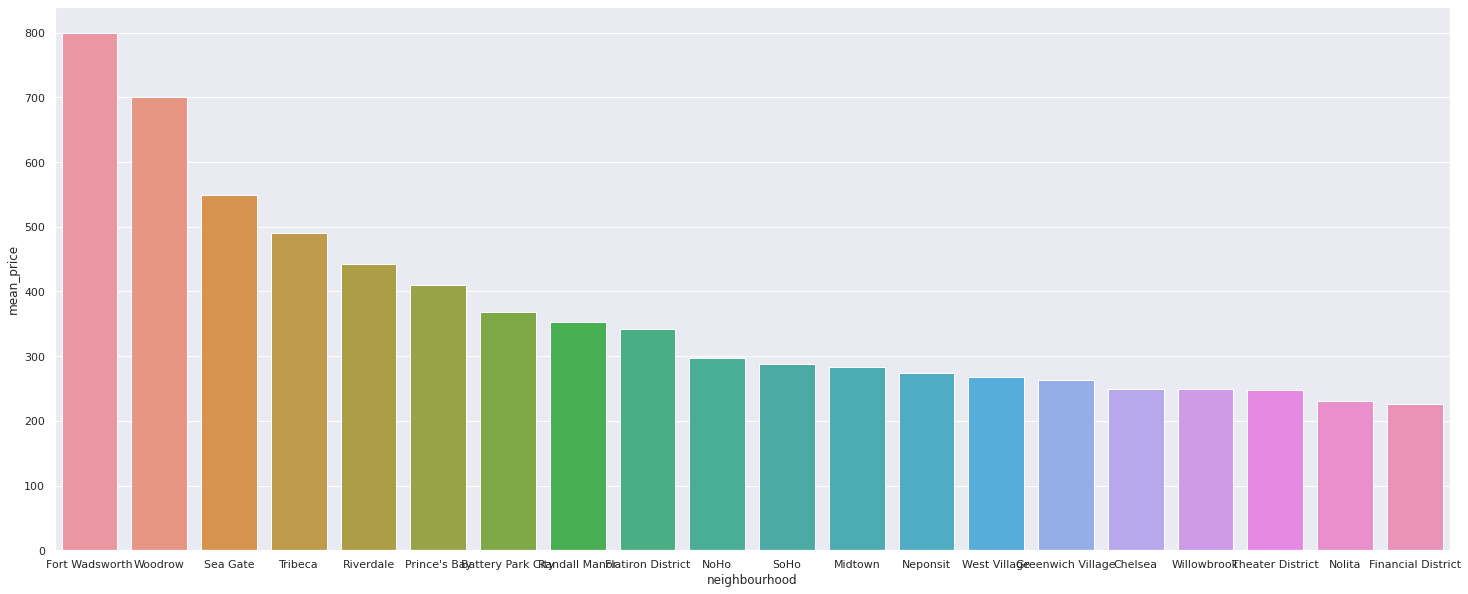

In [108]:
plt.figure(figsize=(25, 10))
sns.barplot(x="neighbourhood", y="mean_price", data=df_neigh_pd)
plt.show()

# In Summary:

I chose to create an Airbnb price predicting model because it provides valuable information to anyone looking to rent property in New York City.  My model works by drawing on information from over forty thousand Airbnb property listings from 2019.  That information was obtained from a dataset which can be found here: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

By identifying trends in Airbnb property listings throughout NYC, my model solves the problem of how to know you are getting a reasonable price for an Airbnb property.  To run this model in a production like environment there is still far more information that would need to be obtained.  

To truly know how much a rental property should go for per night, there are other factors to consider, such as: total square footage of your room, house, or apartment, the condition and cleanliness of the property you want to rent, amenities included with the property, the convenience of the property in terms of stores and other places of interest within the vicinity of the property, what modes of transportation are closeby, the scenic view surrounding the property, and many others.

To maintain this model going forward, much of the information mentioned above would have to be incorporated into the dataset.  Additionally, the dataset would have to be updated, at least on an annual basis.  Overall though, I believe my project could potentially provide a valuable service, both to renters and to the Airbnb company. 


# Questions?